In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from copy import deepcopy

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

In [42]:
from fastai.vision import *
from fastai.tabular import *
from fastai.text import *
from fastai.metrics import error_rate, accuracy
from fastai import *

## Setups

In [4]:
# use GPU for processing if available
USE_CUDA = torch.cuda.is_available()
USE_CUDA = USE_CUDA and True
device = torch.device("cuda" if USE_CUDA else "cpu")
device

device(type='cuda')

In [5]:
torch.cuda.device_count()

2

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.set_device(1)

In [8]:
np.random.seed(42)

## Load records

In [44]:
PATH = "/home/mondher/Documents/Thibault/GPU Tests/python/ofighters/notebooks/"

In [9]:
def load_records(paths):
    """Load all the given files into one record dictionary"""
    records = {"obs" : [], "sol" : []}
    if not isinstance(paths, list):
        paths = [paths]
    for path in paths:
        if not path.endswith(".orec"):
            path += ".orec"
        with open(path , "rb") as file:
            content = pickle.load(file)
            if isinstance(content, dict):
                # print(content["sol"])
                records["obs"].extend(content["obs"])
                records["sol"].extend(content["sol"])
            else:
                raise Exception("Bad file content : dict expected")
    return records

In [10]:
record_path = os.path.join("..", "ofighter_records")

In [11]:
files = glob.glob(os.path.join(record_path, "ofighter_record_*.orec"))
files = glob.glob(os.path.join(record_path, "ofighter_record_19-07-09-14-18-13.orec"))

In [12]:
dataset = load_records(files)

## Look at datas

In [13]:
frame = dataset["obs"][0]
frame

array([[ 0.],
       [ 1.],
       [18.],
       [17.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [14]:
reward = int(frame[0])
reward

0

In [15]:
can_shoot = bool(frame[1])
can_shoot

True

In [16]:
pointing = (int(frame[2]), int(frame[3]))
pointing

(18, 17)

In [17]:
dim = (int(frame[4]), int(frame[5]))
dim

(400, 400)

In [18]:
pos = (int(frame[6]), int(frame[7]))
pos

(319, 184)

In [19]:
ship_map = frame[8:8+(dim[0]*dim[1])]
print(len(ship_map)/dim[0])
print(sum(ship_map))
ship_map

400.0
[1333.]


array([[0.],
       [0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.],
       [0.]])

In [20]:
ship_map = ship_map.reshape(dim[0], dim[1])

In [21]:
laser_map = frame[8+(dim[0]*dim[1]):8+(2*dim[0]*dim[1])]
print(len(laser_map)/dim[0])
print(sum(laser_map))
laser_map

400.0
[78.]


array([[0.],
       [0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.],
       [0.]])

In [22]:
laser_map = laser_map.reshape(dim[0], dim[1])

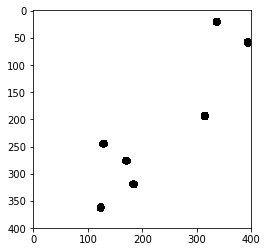

In [23]:
im = plt.imshow(ship_map, cmap="binary")
plt.show()

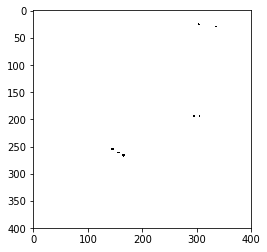

In [24]:
im = plt.imshow(laser_map, cmap="binary")
plt.show()

# Part 1 : model based on linear input

## Preprocessing

In [94]:
# only keep observations informations that are not images
vector_obs = []
for obs in dataset["obs"]:
    vector_obs.append(obs[0:8])

In [95]:
# dimention of the map
dim = (int(vector_obs[0][4]), int(vector_obs[0][5]))

In [96]:
# we normalize the values of output so they are all between 0 and 1
outputs = deepcopy(dataset["sol"])
for i, elt in enumerate(outputs):
    # index of parameters that represent a position on the map
    pos_param = [(2, 3)]
    for pos in pos_param:
        outputs[i][pos[0]] /= dim[0]
        outputs[i][pos[1]] /= dim[1]
outputs

[array([[0.    ],
        [0.    ],
        [0.05  ],
        [0.0575]]), array([[0.    ],
        [0.    ],
        [0.5325],
        [0.665 ]]), array([[1.    ],
        [0.    ],
        [0.5375],
        [0.39  ]]), array([[1.    ],
        [0.    ],
        [0.6925],
        [0.255 ]]), array([[1.  ],
        [0.  ],
        [0.83],
        [0.25]]), array([[1.    ],
        [0.    ],
        [0.8975],
        [0.3275]]), array([[0.    ],
        [0.    ],
        [0.905 ],
        [0.3175]]), array([[0.  ],
        [1.  ],
        [0.98],
        [0.63]]), array([[0.    ],
        [0.    ],
        [0.9825],
        [0.59  ]]), array([[0.   ],
        [1.   ],
        [0.99 ],
        [0.555]]), array([[0.    ],
        [1.    ],
        [0.9175],
        [0.585 ]]), array([[0.    ],
        [1.    ],
        [0.7125],
        [0.6575]]), array([[0.    ],
        [1.    ],
        [0.6225],
        [0.71  ]]), array([[0.   ],
        [1.   ],
        [0.635],
        [0.71 ]]), a

In [97]:
training_size = int(0.8 * len(dataset["obs"]))

In [98]:
x_train, y_train = vector_obs[0:training_size], outputs[0:training_size]
x_valid, y_valid = vector_obs[training_size:], outputs[training_size:]
len(x_train), len(x_valid)

(66, 17)

Size of input and output.

In [99]:
np.array(x_valid).shape

(17, 8, 1)

In [100]:
np.array(y_valid).shape

(17, 4, 1)

## Model

In [117]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(8, 15)
        self.linear2 = nn.Linear(15, 4)

    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

vect_model = SimpleModel().to(device)
print(vect_model)

SimpleModel(
  (linear1): Linear(in_features=8, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=4, bias=True)
)


## Training

In [102]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
x_train,y_train,x_valid,y_valid = map(lambda x : x.squeeze(), (x_train,y_train,x_valid,y_valid))
x_train,y_train,x_valid,y_valid = map(lambda x : x.float(), (x_train,y_train,x_valid,y_valid))

In [103]:
x_train.shape

torch.Size([66, 8])

In [104]:
bs=2

In [105]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [106]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([2, 8]), torch.Size([2, 4]))

In [107]:
x.min(), x.max()

(tensor(0., device='cuda:1'), tensor(400., device='cuda:1'))

In [108]:
y.min(), y.max()

(tensor(0., device='cuda:1'), tensor(1., device='cuda:1'))

In [109]:
vect_model(x).shape

torch.Size([2, 4])

In [118]:
loss_func = nn.MSELoss()
learn = Learner(data, vect_model, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


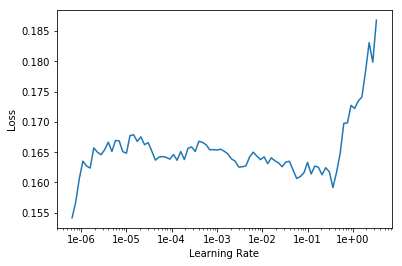

In [119]:
learn.lr_find()
learn.recorder.plot()

In [120]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.159150,0.221480,00:01
1,0.151013,0.173320,00:01
2,0.147713,0.160233,00:01
3,0.146719,0.158499,00:01
4,0.150722,0.165104,00:01
5,0.151356,0.175246,00:01
6,0.153101,0.161084,00:01
7,0.152340,0.167389,00:01
8,0.150684,0.167614,00:01
9,0.151513,0.167473,00:01


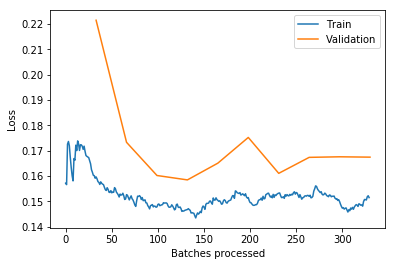

In [121]:
learn.recorder.plot_losses()

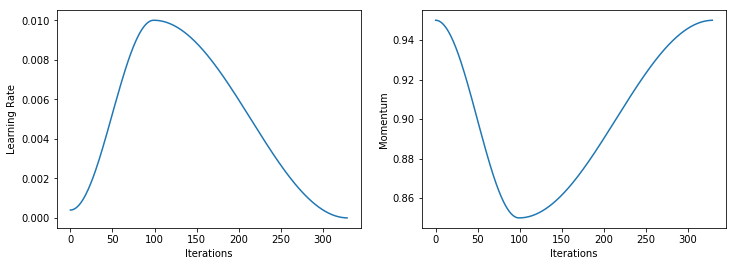

In [122]:
learn.recorder.plot_lr(show_moms=True)

## Testing

In [123]:
vect_model.eval()

SimpleModel(
  (linear1): Linear(in_features=8, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=4, bias=True)
)

In [124]:
with torch.no_grad():
    # 0 reward, can shoot, I point toward (0,0),the map is (400,400), I am in (100,100)
    x = torch.tensor([0, 1, 0, 0, 400, 400, 100, 100]).float().cuda()
    out = vect_model(x)
    # output :
    # tensor([0.5423, 0.5103, 0.4227, 0.5134], device='cuda:0',
    # We should shoot, not convinced (0.5423)
    # We should thrust, not convinced (0.5103)
    # We should point toward 400 * (0.4227, 0.5134) = 169, 205
out

tensor([0.3359, 0.4453, 0.5936, 0.5464], device='cuda:1')

In [125]:
sol = np.array([
    out[0] > 0.5,
    out[1] > 0.5,
    int(out[2] * 400),
    int(out[3] * 400),
])
sol

array([  0,   0, 237, 218])

In [126]:
vect_model.train()

SimpleModel(
  (linear1): Linear(in_features=8, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=4, bias=True)
)

Note that at this point we don't expect him to be good with so few informations of the battlefield. We only want to make sure that everything is working as intended.

Still it could be fun to try this model in game.

In [300]:
name = "part1_09-07-19_sIAmple_pickle"
with open(name, "wb+") as file:
    pickle.dump(vect_model, file)

In [301]:
name = "part1_09-07-19_sIAmple_fastai"
learn.save(name)

In [302]:
name = "part1_09-07-19_sIAmple_pytorch"
torch.save(vect_model, name)

# Part 2 : model based on image input

## Preprocessing

In [127]:
# dimention of the map
dim = (int(dataset["obs"][0][4]), int(dataset["obs"][0][5]))

In [128]:
# only keep observations informations that are images
# and reshape the images to there original form
img_obs = []
for obs in dataset["obs"]:
    img1 = obs[8:8+dim[0]*dim[1]]
    img2 = obs[8+dim[0]*dim[1]:]
    imgs = np.array([img1, img2]).reshape((2,dim[0],dim[1]))
    img_obs.append(imgs)

In [129]:
# we normalize the values of output so they are all between 0 and 1
outputs = deepcopy(dataset["sol"])
for i, elt in enumerate(outputs):
    # index of parameters that represent a position on the map
    pos_param = [(2, 3)]
    for pos in pos_param:
        outputs[i][pos[0]] /= dim[0]
        outputs[i][pos[1]] /= dim[1]

In [130]:
training_size = int(0.8 * len(dataset["obs"]))

In [131]:
x_train, y_train = img_obs[0:training_size], outputs[0:training_size]
x_valid, y_valid = img_obs[training_size:], outputs[training_size:]
len(x_train), len(x_valid)

(66, 17)

Size of input and output.

In [132]:
np.array(x_valid).shape

(17, 2, 400, 400)

In [133]:
np.array(y_valid).shape

(17, 4, 1)

## Model

In [134]:
# print module layer
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

In [156]:
class IAmageNet(nn.Module):

    def __init__(self):
        super(IAmageNet, self).__init__()
        # input are ship map and laser map (400x400)
        # 2 input image channel, 8 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        # printlayer
        self.print_layer = Print()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 46 * 46, 1024)  # 46x46 from image dimension
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 32)
        # TODO add integer observations by concatenating a vector here
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # self.print_layer(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [136]:
img_net = IAmageNet().to(device)
print(img_net)

IAmageNet(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (print_layer): Print()
  (fc1): Linear(in_features=135424, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


## Training

In [137]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
x_train,y_train,x_valid,y_valid = map(lambda x : x.squeeze(), (x_train,y_train,x_valid,y_valid))
x_train,y_train,x_valid,y_valid = map(lambda x : x.float(), (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([66, 2, 400, 400])

In [138]:
bs=1

In [139]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs, device=device)

In [140]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([1, 2, 400, 400]), torch.Size([1, 4]))

In [141]:
x.min(), x.max()

(tensor(0., device='cuda:1'), tensor(1., device='cuda:1'))

In [142]:
y.min(), y.max()

(tensor(0., device='cuda:1'), tensor(1., device='cuda:1'))

In [143]:
img_net(x).shape

torch.Size([1, 4])

In [144]:
loss_func = nn.MSELoss()
learn = Learner(data, img_net, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


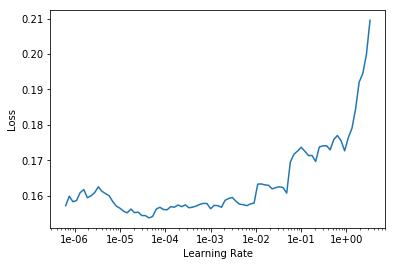

In [145]:
learn.lr_find()
learn.recorder.plot()

In [146]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.160555,0.169485,00:04
1,0.162527,0.166953,00:03
2,0.157284,0.169981,00:03
3,0.153106,0.169937,00:03
4,0.153380,0.164194,00:03
5,0.151123,0.170205,00:03
6,0.153653,0.167688,00:03
7,0.153751,0.165464,00:03
8,0.153777,0.166228,00:03
9,0.151580,0.166498,00:03


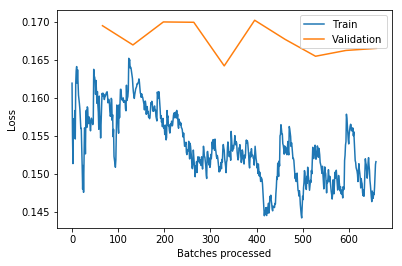

In [147]:
learn.recorder.plot_losses()

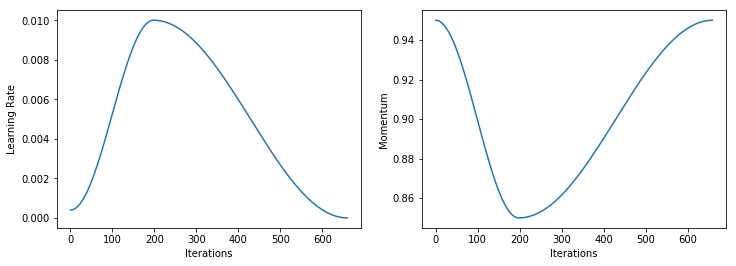

In [148]:
learn.recorder.plot_lr(show_moms=True)

## Testing

In [158]:
img_net.eval()

IAmageNet(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (print_layer): Print()
  (fc1): Linear(in_features=135424, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)

In [180]:
with torch.no_grad():
    # ship and laser map from the beginning
    x = np.array([[ship_map, laser_map]])
    x = torch.tensor(x).float().cuda()
    out = img_net(x)[0]
out

tensor([0.3368, 0.4590, 0.6016, 0.5429], device='cuda:1')

In [181]:
sol = np.array([
    out[0] > 0.5,
    out[1] > 0.5,
    int(out[2] * 400),
    int(out[3] * 400),
])
sol

array([  0,   0, 240, 217])

In [ ]:
img_net.train()

Note that at this point we still don't expect him to be good with so few informations of the battlefield. We only want to make sure that everything is working as intended.

Still it could be fun to try this model in game.

In [157]:
name = "part2_09-07-19_IAmage_pickle"
with open(name, "wb+") as file:
    pickle.dump(img_net, file)

PicklingError: Can't pickle <class '__main__.IAmageNet'>: it's not the same object as __main__.IAmageNet

In [ ]:
name = "part2_09-07-19_IAmage_fastai"
learn.save(name)

In [ ]:
name = "part2_09-07-19_IAmage_pytorch"
torch.save(img_net, name)

# Part 3 : model based on linear and image input

## Preprocessing

In [248]:
# dimention of the map
dim = (int(dataset["obs"][0][4]), int(dataset["obs"][0][5]))

In [249]:
# we separate input in two. the 1D and 2D inputs.

vect_obs = []
imgs_obs = []

for obs in dataset["obs"]:
    # 1D input
    vect_obs.append(np.array(obs[0:8]))
    
    # 2D input : we reshape them
    img1 = obs[8:8+dim[0]*dim[1]]
    img2 = obs[8+dim[0]*dim[1]:]
    imgs = np.array([img1, img2]).reshape((2,dim[0],dim[1]))
    imgs_obs.append(imgs)

In [250]:
# we normalize the values of output so they are all between 0 and 1
outputs = deepcopy(dataset["sol"])
for i, elt in enumerate(outputs):
    # index of parameters that represent a position on the map
    pos_param = [(2, 3)]
    for pos in pos_param:
        outputs[i][pos[0]] /= dim[0]
        outputs[i][pos[1]] /= dim[1]

In [251]:
# size of the training dataset
t_size = int(0.8 * len(dataset["obs"]))

In [252]:
vect_train, imgs_train, y_train = vect_obs[0:t_size], imgs_obs[0:t_size], outputs[0:t_size]
vect_valid, imgs_valid, y_valid = vect_obs[t_size:], imgs_obs[t_size:], outputs[t_size:]
len(y_train), len(y_valid)

(66, 17)

In [253]:
np.array(vect_valid).shape

(17, 8, 1)

In [254]:
np.array(imgs_valid).shape

(17, 2, 400, 400)

In [255]:
np.array(y_valid).shape

(17, 4, 1)

## Model

In [256]:
# print module layer
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

In [257]:
class BrAInet(nn.Module):

    def __init__(self):
        super(BrAInet, self).__init__()
        # input are ship map and laser map (400x400)
        # 2 input image channel, 8 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 46 * 46, 1024)  # 46x46 from image dimension
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 24)
        # injection of the second size 8 input (1D input)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, vect, imgs):
        x = imgs
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # self.print_layer(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        combined = torch.cat((x.view(x.size(0), -1), 
                              vect.view(vect.size(0), -1)), dim=1)
        # x = torch.cat((x, vect), dim=1)
        
        combined = torch.sigmoid(self.fc4(combined))
        return combined

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


brain_net = BrAInet().to(device)
print(brain_net)

BrAInet(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=135424, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


## Training

In [258]:
train_valid = (vect_train, imgs_train, y_train, vect_valid, imgs_valid, y_valid)
train_valid = map(torch.tensor, train_valid)
train_valid = map(lambda x : x.squeeze(), train_valid)
train_valid = map(lambda x : x.float(), train_valid)
(vect_train, imgs_train, y_train, vect_valid, imgs_valid, y_valid) = train_valid

In [259]:
bs = 32

In [260]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return (self.x1[i], self.x2[i]), self.y[i]

train_ds = ConcatDataset(vect_train, imgs_train, y_train)
valid_ds = ConcatDataset(vect_valid, imgs_valid, y_valid)

In [261]:
def my_collate(batch):
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    print("(x1, x2), y", (x1, x2), y)
    # x1 = to_data(x1)
    # x1 = list(zip(*x1))
    # x1 = torch.stack(x1[0]), torch.stack(x1[1])
    # x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

In [262]:
train_dl = DataLoader(train_ds, bs//2)#, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs)#, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device)#, collate_fn=my_collate, path=PATH)

In [263]:
(vect,imgs),y = next(iter(data.train_dl))
print(len(next(iter(data.train_dl))))
print(vect)
print(imgs)
print(y)

2
tensor([[  0.,   1.,  18.,  17., 400., 400., 319., 184.],
        [  0.,   1.,  20.,  23., 400., 400., 319., 184.],
        [  0.,   1., 213., 266., 400., 400., 319., 184.],
        [  0.,   1., 215., 156., 400., 400., 319., 184.],
        [  0.,   1., 277., 102., 400., 400., 319., 184.],
        [  0.,   1., 332., 100., 400., 400., 319., 184.],
        [  0.,   1., 359., 131., 400., 400., 319., 184.],
        [  0.,   1., 362., 127., 400., 400., 319., 184.],
        [  0.,   1., 392., 252., 400., 400., 324., 189.],
        [  0.,   1., 393., 236., 400., 400., 324., 189.],
        [  0.,   1., 396., 222., 400., 400., 331., 192.],
        [  0.,   1., 367., 234., 400., 400., 336., 198.],
        [  0.,   1., 285., 263., 400., 400., 331., 204.],
        [  0.,   1., 249., 284., 400., 400., 325., 209.],
        [  0.,   1., 254., 284., 400., 400., 319., 214.],
        [  0.,   1., 357., 256., 400., 400., 319., 214.]], device='cuda:1')
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          

In [264]:
vect.min(), vect.max()

(tensor(0., device='cuda:1'), tensor(400., device='cuda:1'))

In [265]:
imgs.min(), imgs.max()

(tensor(0., device='cuda:1'), tensor(1., device='cuda:1'))

In [266]:
y.min(), y.max()

(tensor(0., device='cuda:1'), tensor(1., device='cuda:1'))

In [267]:
brain_net(vect, imgs).shape

torch.Size([16, 4])

In [268]:
loss_func = nn.MSELoss()
learn = Learner(data, brain_net, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


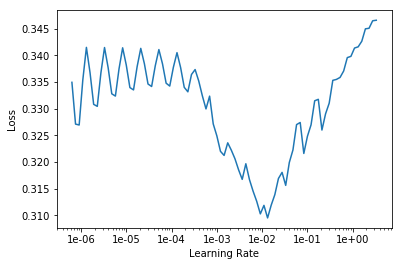

In [269]:
learn.lr_find()
learn.recorder.plot()

In [270]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.309033,0.409850,00:00
1,0.310304,0.451081,00:00
2,0.300477,0.388824,00:00
3,0.296391,0.369750,00:00
4,0.294481,0.328901,00:00
5,0.292489,0.324362,00:00
6,0.291322,0.323903,00:00
7,0.289700,0.323616,00:00
8,0.285680,0.318580,00:00
9,0.282159,0.316489,00:00


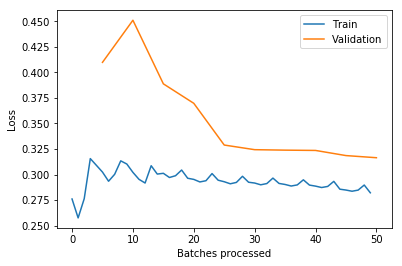

In [271]:
learn.recorder.plot_losses()

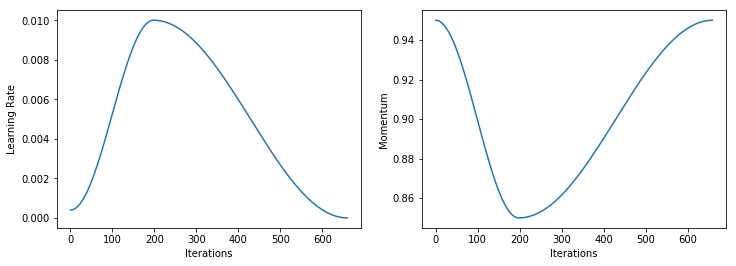

In [231]:
learn.recorder.plot_lr(show_moms=True)

## Testing